<a href="https://colab.research.google.com/github/cychen116/ExploratoryDataAnalysis_practice/blob/main/04_EDA_practice_TimeSeries_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
data_dir = "/content/drive/My Drive/Colab Notebooks/EMSE 6574_c/Data/StockPrice"
!ls '{data_dir}'
# Data download from Nasdaq, https://www.nasdaq.com/

'Advanced Micro Devices.csv'   Facebook.csv		    Tesla.csv
 Amazon.com.csv		       Microsoft.csv		    Zynga.csv
 APPLE.csv		      'QUALCOMM Incorporated.csv'
'Ciso System.csv'	       Starbucks.csv


In [3]:
# Data
import pandas as pd
import numpy as np
# Visulization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
sns.set_style('darkgrid')

In [4]:
#Stationarity Exploration
from statsmodels.tsa.stattools import kpss, adfuller
#Trend Removal & Differencing
from scipy.stats import boxcox
from statsmodels.tsa.statespace.tools import diff
import warnings
#SARIMA Modeling
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
#SARIMA Model Fitting
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
#SARIMA Test Results
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from tqdm import tqdm_notebook
from itertools import product
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

# Data Loading & Wrangling

In [6]:
df = pd.read_csv(f'{data_dir}/APPLE.csv')
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,11/06/2020,$118.69,114457900,$118.32,$119.2,$116.13
1,11/05/2020,$119.03,126387100,$117.95,$119.62,$116.8686
2,11/04/2020,$114.95,138235500,$114.14,$115.59,$112.35
3,11/03/2020,$110.44,107624400,$109.66,$111.49,$108.73
4,11/02/2020,$108.77,122866900,$109.11,$110.68,$107.32


In [7]:
#Rename Colmumns
df.rename(columns={' Close/Last':'Close', 
                      ' Volume':'Volume',
                      ' Open':'Open',
                      ' High':'High',
                      ' Low':'Low'},inplace=True)

In [8]:
#Delete $ sign
colscheck = df.columns
df[colscheck] = df[colscheck].replace({'\$':''}, regex = True)

In [9]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])
 
# Check column data types to verify
df.dtypes

# Set index to 'Date' column for convenience
df = df.set_index('Date')

In [10]:
# Convert other Columns to float
colscheck = df.columns
df[colscheck] = df[colscheck].astype(float, errors = 'raise')

In [11]:
#Final Check
df.head()

,Close,Volume,Open,High,Low
Date,,,,,
2020-11-06,118.69,114457900.0,118.32,119.20,116.1300
2020-11-05,119.03,126387100.0,117.95,119.62,116.8686
2020-11-04,114.95,138235500.0,114.14,115.59,112.3500
2020-11-03,110.44,107624400.0,109.66,111.49,108.7300
2020-11-02,108.77,122866900.0,109.11,110.68,107.3200


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2020-11-06 to 2010-11-09
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2517 non-null   float64
 1   Volume  2517 non-null   float64
 2   Open    2517 non-null   float64
 3   High    2517 non-null   float64
 4   Low     2517 non-null   float64
dtypes: float64(5)
memory usage: 118.0 KB


# EDA & Resampling

 -  weekly
 -  monthly

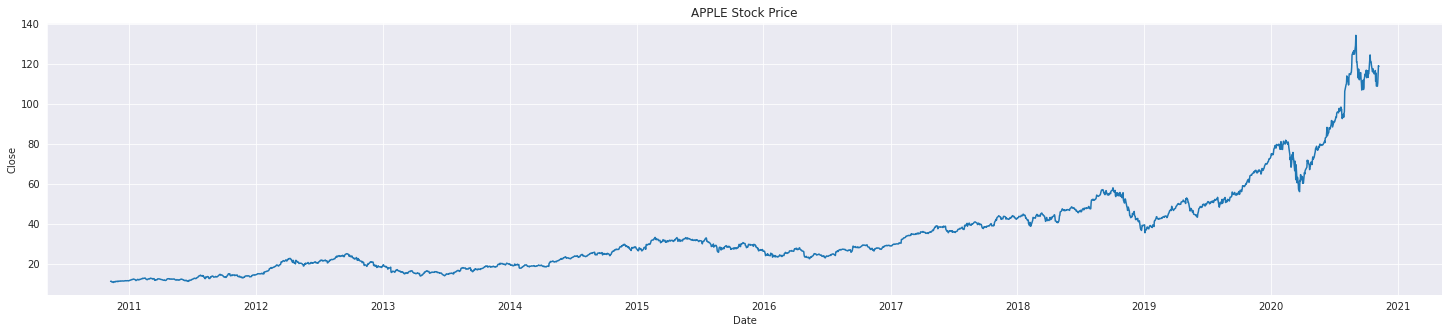

In [13]:
fig, ax = plt.subplots(figsize = (25, 5))
ax.set_title('APPLE Stock Price');
sns.lineplot(data = df, x = 'Date', y = 'Close', ax = ax);

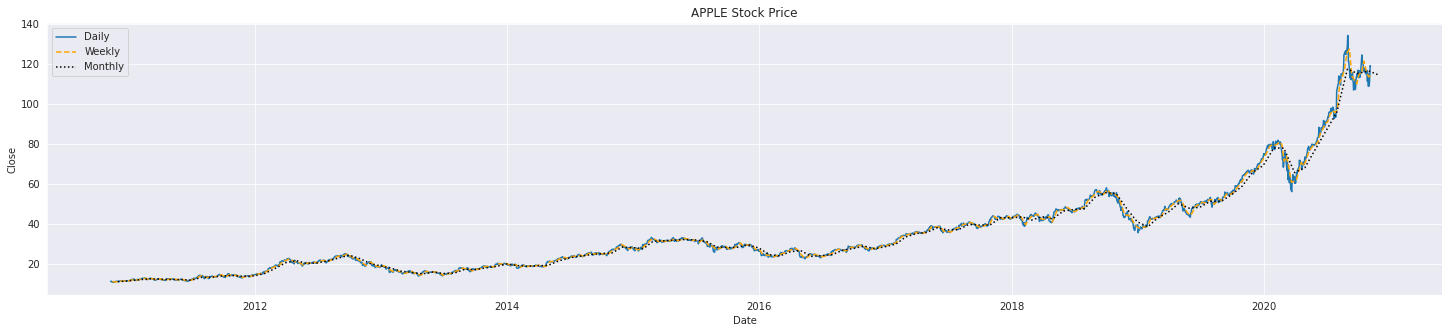

In [14]:
# Resample to weekly timeframe and use the mean
# as the aggregate for the week
weeklyDF = df.resample('W').mean()

# Resample to monthly timeframe and use the
# mean as the aggregate for the month
monthlyDF = df.resample('M').mean()

# Plot all graphs on plot to compare
fig, ax = plt.subplots(figsize = (25, 5))
ax.set_title('APPLE Stock Price');
sns.lineplot(data = df, x = 'Date', y = 'Close', ax = ax);
sns.lineplot(data = weeklyDF, x = 'Date', y = 'Close', ax = ax, color = 'orange', linestyle = '--');
sns.lineplot(data = monthlyDF, x = 'Date', y = 'Close', ax = ax, color = 'black', linestyle = ':');
ax.legend(labels = ['Daily', 'Weekly', 'Monthly']);

## Moving Average

In [15]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()  # define window to apply the moving average model to smooth the time series, and highlight different trends
    
    plt.figure(figsize=(18,5))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

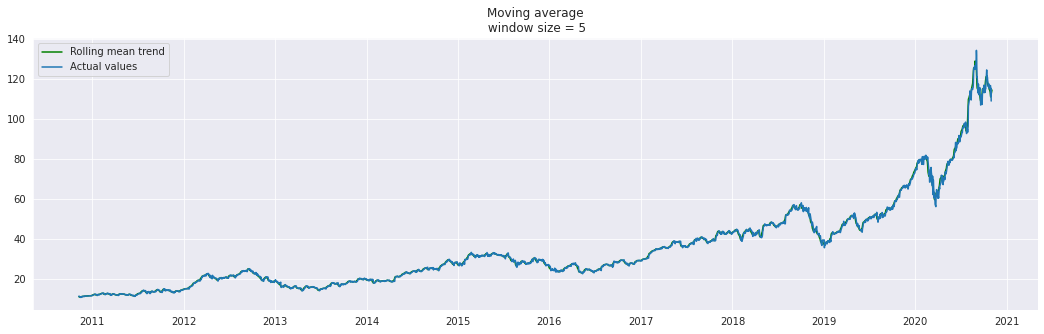

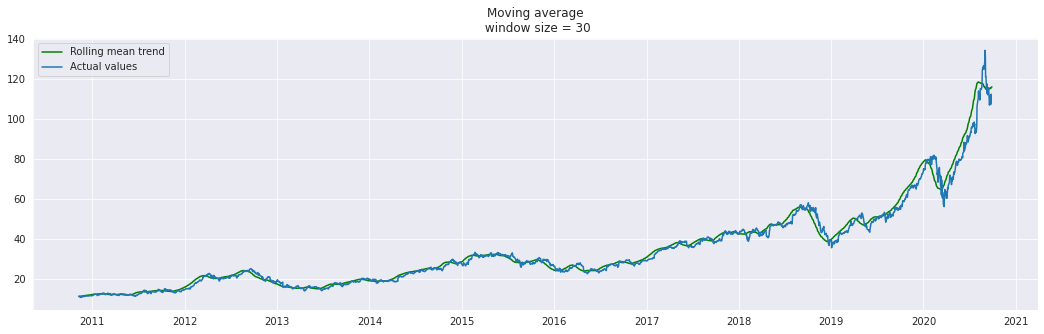

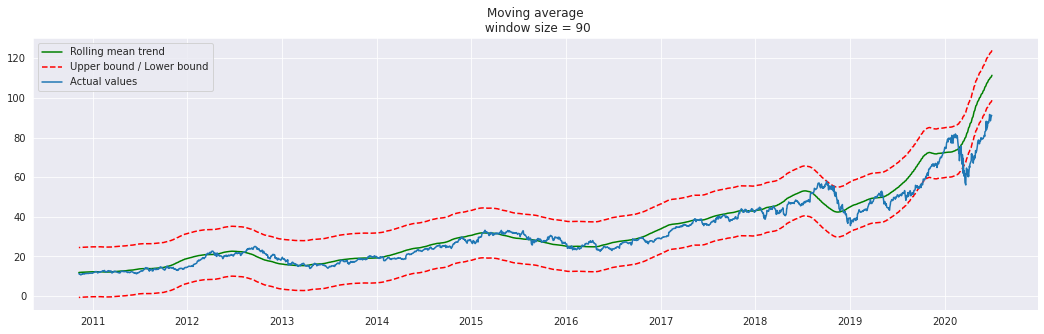

In [16]:
#Smooth by the previous 5 days (by week)
plot_moving_average(df.Close, 5)
#Smooth by the previous month (30 days)
plot_moving_average(df.Close, 30)
#Smooth by previous quarter (90 days)
plot_moving_average(df.Close, 90, plot_intervals=True)

## Smoothing

### Exponential Smoothing

In [17]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

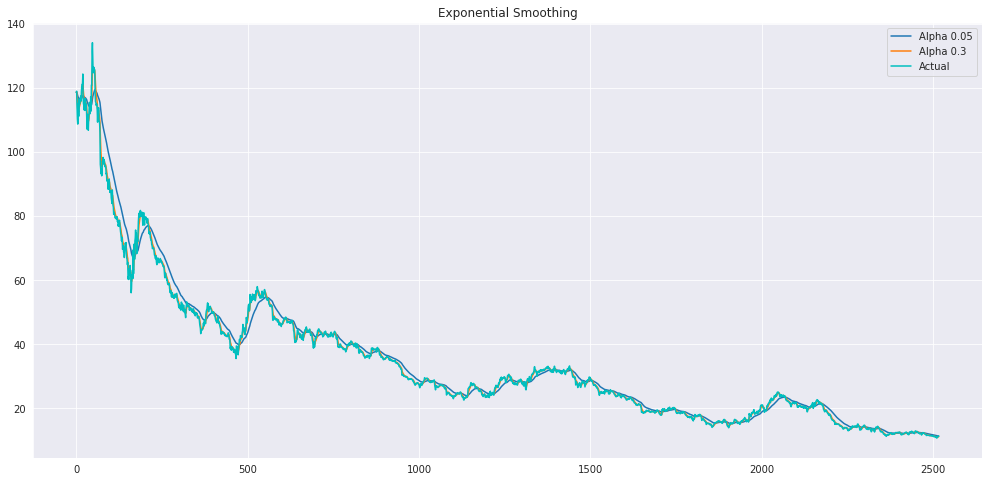

In [18]:
plot_exponential_smoothing(df.Close, [0.05, 0.3])

### Double Exponential Smoothing

In [19]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

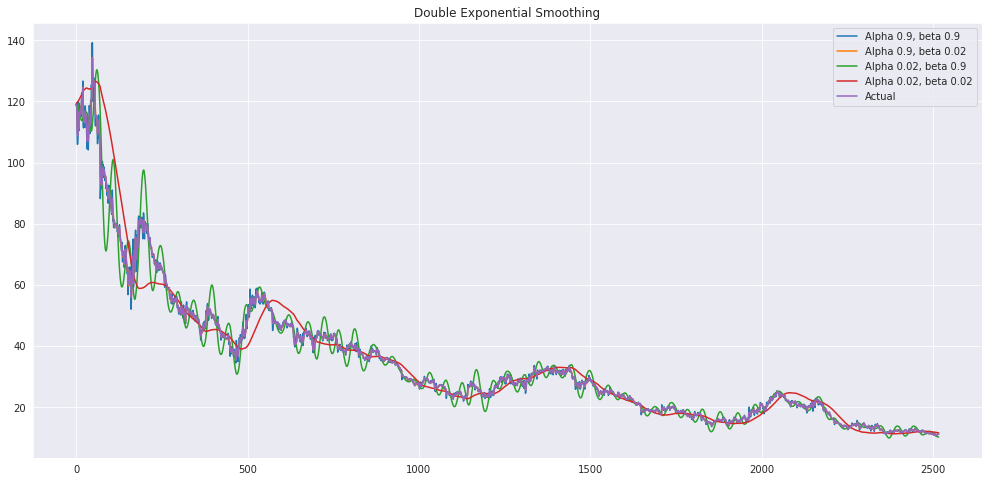

In [20]:
plot_double_exponential_smoothing(df.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Seasonality Exploration

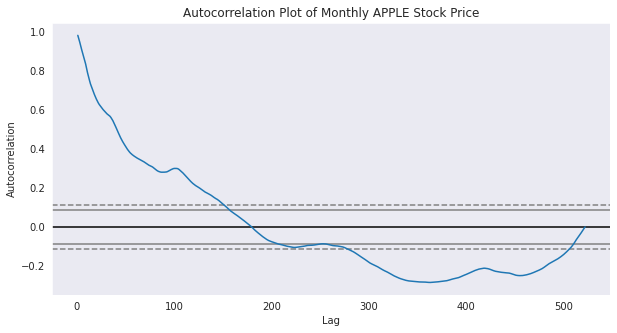

In [21]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.set_title('Autocorrelation Plot of Monthly APPLE Stock Price');
autocorrelation_plot(weeklyDF['Close'], ax = ax);

Based on the ACF plot above, there does not seem to be any seasonality; the plot does indicate that it is a **non-stationary** time series so differencing is needed.

## Stationarity Exploration

A time series is stationary if there is no change in mean, variance, and covariance over time. I will test for stationarity using the KPSS (Kwiatkowski–Phillips–Schmidt–Shin) test and ADF (Augmented Dickey-Fuller) test. KPSS tests for trend and level stationarity. 

We want to accept the null hypotheses for the KPSS tests. ADF tests for a unit root, an indication of non-stationarity. We want to reject the null hypothesis for the ADF test.

In [22]:
def test_stationarity(data, verbose=False):
    is_trend_stationary = False
    is_level_stationary = False
    has_no_unit_root = False

    if verbose:
        print('KPSS TESTING'.center(50, '='))

    # KPSS results
    for regression_type in ['c', 'ct']:
        kpss_results = kpss(data, regression = regression_type, lags = 'legacy')

        if verbose:
            reg_type_str = 'trend' if regression_type == 'ct' else 'level'
            print(f'Null Hypothesis: The time series exhibits {reg_type_str} stationarity.')
            print(
                f'Test Statistic:        {kpss_results[0]}\n'
                f'p-value:               {kpss_results[1]}\n'
                f'Lags Used:             {kpss_results[2]}\n'
                f'Critical Value (1%):   {kpss_results[3]["1%"]}\n' 
                f'Critical Value (2.5%): {kpss_results[3]["2.5%"]}\n' 
                f'Critical Value (5%):   {kpss_results[3]["5%"]}\n' 
                f'Critical Value (10%):  {kpss_results[3]["10%"]}' 
            )
            print('~' * 50)
        if kpss_results[1] < 0.05 and kpss_results[0] > kpss_results[3]["5%"]:
            if verbose:
                print(
                    f'The p-value is less than 5% and the test statistic is greater than {kpss_results[3]["5%"]}. Null hypothesis is rejected!'
                )
                print('-' * 50)
        else:
            if verbose:
                print(
                    f'The p-value is greater than 5% and the test statistic is less than {kpss_results[3]["5%"]}. Null hypothesis is not rejected!'
                )
                print('-' * 50)
            if regression_type == 'c':
                is_level_stationary = True
            else:
                is_trend_stationary = True

    # ADF results
    adf_results = adfuller(data)
    if verbose:
        print('')
        print('ADF TESTING'.center(50, '='))
        print('Null Hypothesis: The time series has a unit root.')
        print(
            f'Test Statistic:        {adf_results[0]}\n'
            f'p-value:               {adf_results[1]}\n'
            f'Lags Used:             {adf_results[2]}\n'
            f'Observations Used:     {adf_results[3]}\n'
            f'Critical Value (1%):   {adf_results[4]["1%"]}\n' 
            f'Critical Value (5%):   {adf_results[4]["5%"]}\n' 
            f'Critical Value (10%):  {adf_results[4]["10%"]}' 
        )
        print('~' * 50)
    if adf_results[1] < 0.05 and adf_results[0] < adf_results[4]["5%"]:
        if verbose:
            print(
                f'The p-value is less than 5% and the test statistic is less than {adf_results[4]["5%"]}. Null hypothesis is rejected!'
            )
        has_no_unit_root = True
    else:
        if verbose:
            print(
                f'The p-value is greater than 5% and the test statistic is greater than {adf_results[4]["5%"]}. Null hypothesis is not rejected!'
            )

    is_stationary = is_trend_stationary and is_level_stationary and has_no_unit_root
    if verbose:
        result_str = '' if is_stationary else ' NOT' 
        print(f'\n\nDATA IS{result_str} STATIONARY.')

    return is_stationary


In [23]:
test_stationarity(weeklyDF['Close'], verbose = True)

===================KPSS TESTING===================
Null Hypothesis: The time series exhibits level stationarity.
Test Statistic:        2.1001879686855456
p-value:               0.01
Lags Used:             19
Critical Value (1%):   0.739
Critical Value (2.5%): 0.574
Critical Value (5%):   0.463
Critical Value (10%):  0.347
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The p-value is less than 5% and the test statistic is greater than 0.463. Null hypothesis is rejected!
--------------------------------------------------
Null Hypothesis: The time series exhibits trend stationarity.
Test Statistic:        0.3878247931211257
p-value:               0.01
Lags Used:             19
Critical Value (1%):   0.216
Critical Value (2.5%): 0.176
Critical Value (5%):   0.146
Critical Value (10%):  0.119
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The p-value is less than 5% and the test statistic is greater than 0.146. Null hypothesis is rejected!
------------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


False

The time series failed both KPSS tests and the ADF test at a 5% significance level so we have verified that there is non-stationarity present in the time series. To correct for this, we need to difference the time series and remove trend from it.

## Trend Removal & Differencing - Box-Cox Transform

By applying a Box-Cox transform on the time series data, we can detrend the time series which should take care of the KPSS tests. As shown by the output below, we see that that is indeed the case, but the data is still not stationary yet.

In [24]:
weeklyDF['Close_BoxCox'], boxcox_lambda = boxcox(weeklyDF['Close'])
test_stationarity(weeklyDF['Close_BoxCox'], verbose = True)

===================KPSS TESTING===================
Null Hypothesis: The time series exhibits level stationarity.
Test Statistic:        2.4945416881725144
p-value:               0.01
Lags Used:             19
Critical Value (1%):   0.739
Critical Value (2.5%): 0.574
Critical Value (5%):   0.463
Critical Value (10%):  0.347
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The p-value is less than 5% and the test statistic is greater than 0.463. Null hypothesis is rejected!
--------------------------------------------------
Null Hypothesis: The time series exhibits trend stationarity.
Test Statistic:        0.09100492591279706
p-value:               0.1
Lags Used:             19
Critical Value (1%):   0.216
Critical Value (2.5%): 0.176
Critical Value (5%):   0.146
Critical Value (10%):  0.119
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The p-value is greater than 5% and the test statistic is less than 0.146. Null hypothesis is not rejected!
--------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


False


Now that we have detrended the time series, we should difference the data to pass the ADF test. We need to figure out how many orders of differencing we need by iteratively testing each difference value until we pass the ADF test.

# Pre - SARIMA

## BoxCox : Find Parameter for Model by Ploting

### Decomposition

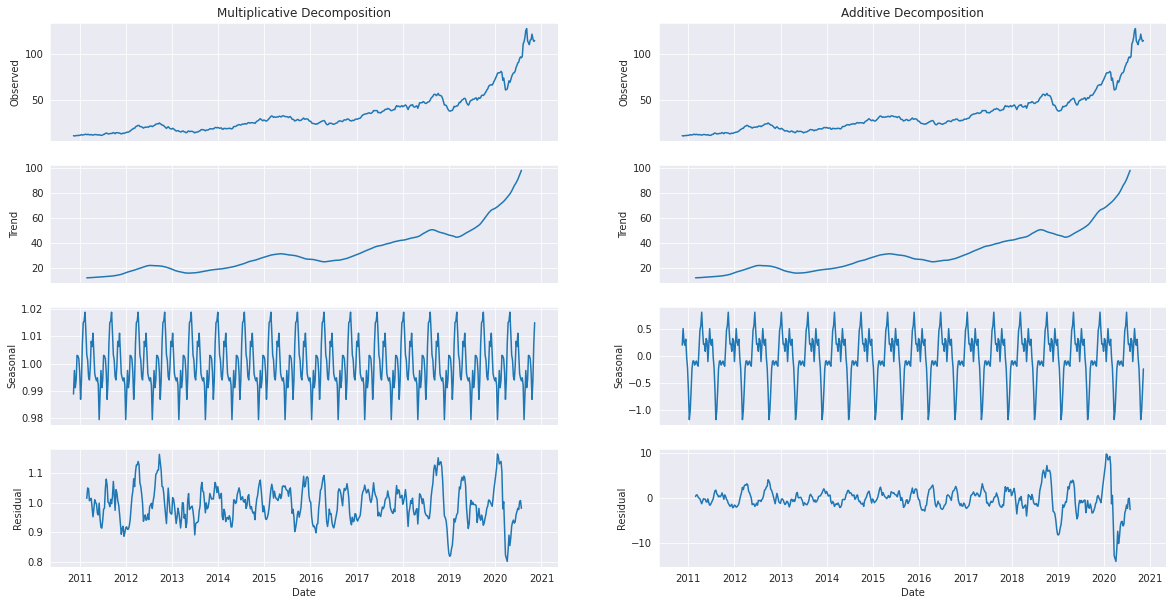

In [27]:
fig, axes = plt.subplots(4, 2, sharex = True, figsize = (20, 10))
multiDecomp = seasonal_decompose(weeklyDF['Close'], model = 'multiplicative', freq = 30)
addDecomp = seasonal_decompose(weeklyDF['Close'], model = 'additive', freq = 30)

# Multiplicative decomposition
sns.lineplot(data = multiDecomp.observed, x = 'Date', y = multiDecomp.observed, ax = axes[0, 0]);
axes[0, 0].set_ylabel('Observed');
sns.lineplot(data = multiDecomp.trend, x = 'Date', y = multiDecomp.trend, ax = axes[1, 0]);
axes[1, 0].set_ylabel('Trend');
sns.lineplot(data = multiDecomp.seasonal, x = 'Date', y = multiDecomp.seasonal, ax = axes[2, 0]);
axes[2, 0].set_ylabel('Seasonal');
sns.lineplot(data = multiDecomp.resid, x = 'Date', y = multiDecomp.resid, ax = axes[3, 0]);
axes[3, 0].set_ylabel('Residual');
axes[0, 0].set_title('Multiplicative Decomposition');

# Additive decomposition
sns.lineplot(data = addDecomp.observed, x = 'Date', y = addDecomp.observed, ax = axes[0, 1]);
axes[0, 1].set_ylabel('Observed');
sns.lineplot(data = addDecomp.trend, x = 'Date', y = addDecomp.trend, ax = axes[1, 1]);
axes[1, 1].set_ylabel('Trend');
sns.lineplot(data = addDecomp.seasonal, x = 'Date', y = addDecomp.seasonal, ax = axes[2, 1]);
axes[2, 1].set_ylabel('Seasonal');
sns.lineplot(data = addDecomp.resid, x = 'Date', y = addDecomp.resid, ax = axes[3, 1]);
axes[3, 1].set_ylabel('Residual');
axes[0, 1].set_title('Additive Decomposition');

### "I" (Integral - d) Parameter Determination

In [25]:
def determine_d(data, max_d=5, verbose=False):
    is_stationary = False
    d = 0
    for diff_num in range(0, max_d + 1):
        if verbose:
            print(f'Testing at differencing order {diff_num}...')
        
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')

            diff_data = diff(data, k_diff = diff_num)
            is_stationary = test_stationarity(diff_data)

            if is_stationary:
                d = diff_num
                break
    else:
        raise ValueError(
            'Could not find a differencing order to satisfy stationarity!'
            f' Try increasing `max_d` (currently {max_d}).'
        )

    if verbose:
        print(f'Best difference order is {d}.')
    
    return d    

In [26]:
d = determine_d(weeklyDF['Close_BoxCox'], verbose = True)

Testing at differencing order 0...
Testing at differencing order 1...
Best difference order is 1.



The "best" integral term was found above (d = 1). This may change depending on further iterations on the model.



### AR" (Autoregressive - p) Parameter Determination

Because the PACF of the lag-1 differenced time series (above left) shows a sharp cutoff at lag 1, this indicates the series could be slightly underdifferenced. We should add in AR terms equal to where the ACF is significant before it drops off, i.e. p = 7.

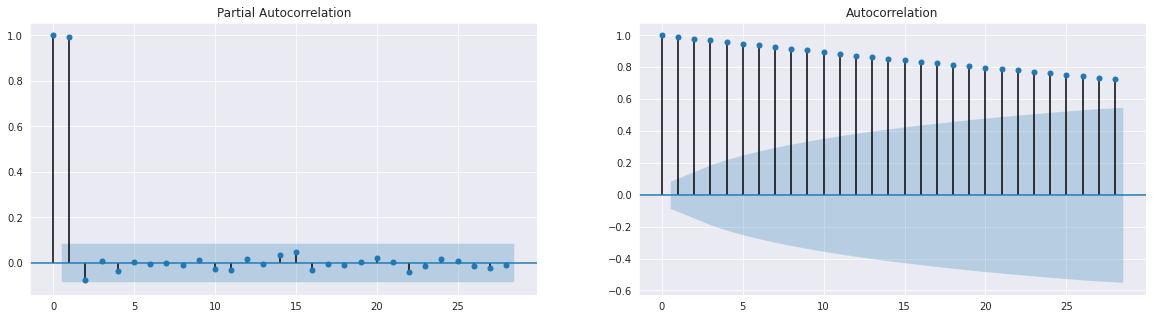

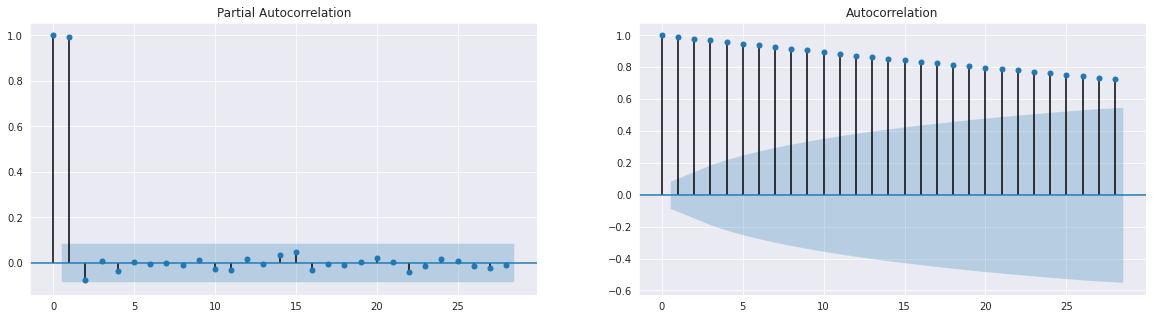

In [28]:
fig, axes = plt.subplots(1, 2, figsize = (20, 5))
plot_pacf(weeklyDF['Close_BoxCox'], ax = axes[0])
plot_acf(weeklyDF['Close_BoxCox'], ax = axes[1])

### MA" (Moving Average - q) Parameter Determination

The ACF of the lag-1 differenced time series doesn't show a sharp cutoff so this doesn't indicate any overdifferencing. No correction is needed using the moving average, i.e., q = 0.

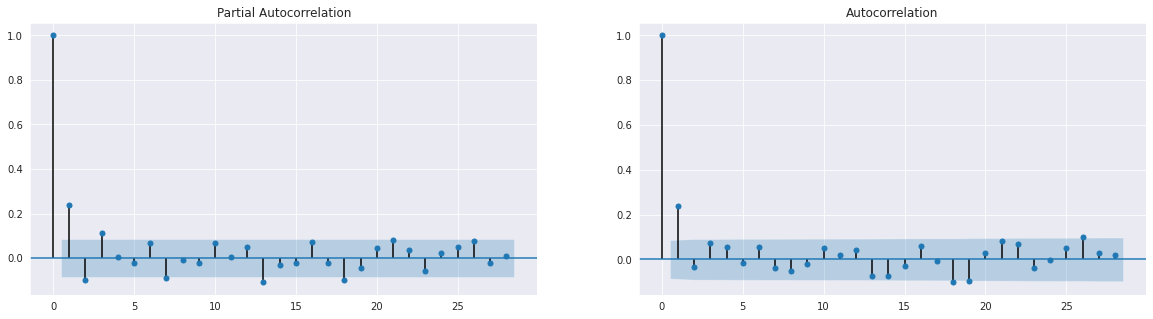

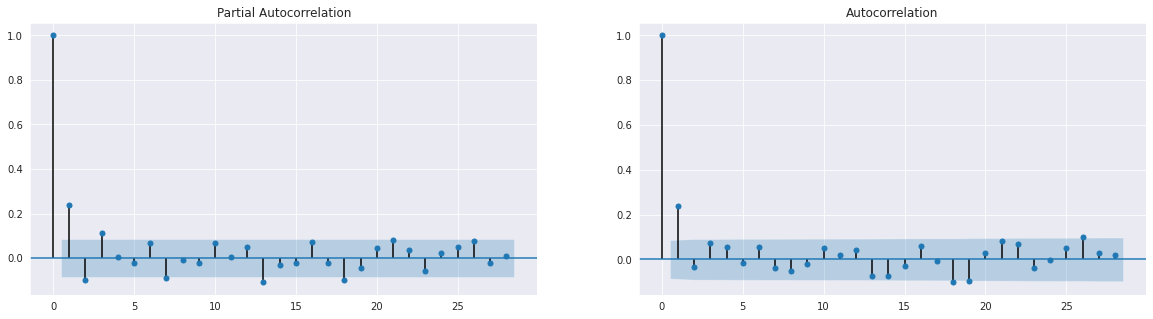

In [29]:
fig, axes = plt.subplots(1, 2, figsize = (20, 5))
plot_pacf(diff(weeklyDF['Close_BoxCox'], k_diff = d), ax = axes[0])
plot_acf(diff(weeklyDF['Close_BoxCox'], k_diff = d), ax = axes[1])

## Non-BoxCox: Plot in Once

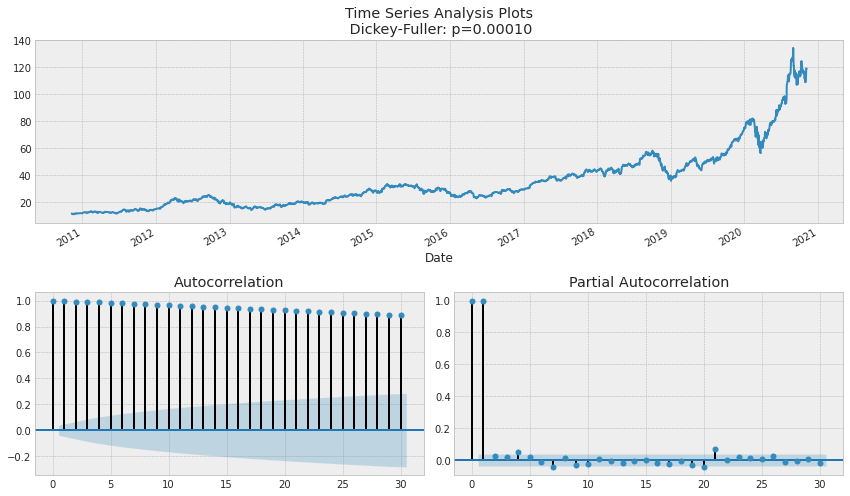

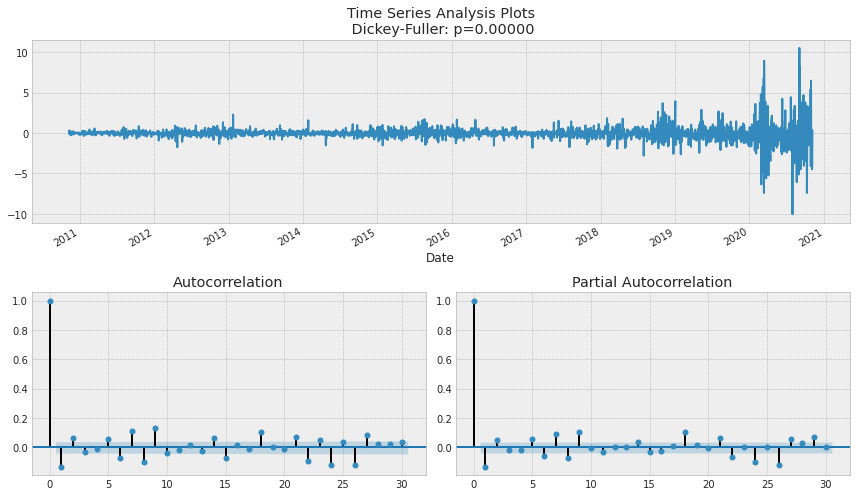

In [30]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df.Close, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = df.Close - df.Close.shift(1)

tsplot(data_diff[1:], lags=30)

# SARIMA Model Fitting

## BoxCox

In [31]:
# Split data into training and test
train_data = weeklyDF.iloc[:weeklyDF.shape[0] - 30].copy()
test_data = weeklyDF.iloc[weeklyDF.shape[0] - 30:].copy()

# Box-Cox transform
train_data['Close_BoxCox'] = boxcox(train_data['Close'], lmbda = boxcox_lambda)
test_data['Close_BoxCox'] = boxcox(test_data['Close'], lmbda = boxcox_lambda)

# Fit SARIMA model with p, q, and d values
# from above. No seasonal order values are
# needed because there isn't any seasonality
sarima_model = SARIMAX(
    endog = train_data['Close_BoxCox'],
    freq = 'W',
    order = (
        7,  # p
        1,  # d
        0   # q
    ),
    trend = [1, 0]
).fit()
print(sarima_model.summary())

                           Statespace Model Results                           
Dep. Variable:           Close_BoxCox   No. Observations:                  492
Model:               SARIMAX(7, 1, 0)   Log Likelihood                1539.667
Date:                Tue, 15 Feb 2022   AIC                          -3061.335
Time:                        06:33:52   BIC                          -3023.567
Sample:                    11-14-2010   HQIC                         -3046.503
                         - 04-12-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.000      2.116      0.034    7.58e-05       0.002
ar.L1          0.2902      0.042      6.957      0.000       0.208       0.372
ar.L2         -0.1397      0.040     -3.515      0.0

In [ ]:
# Split data into training and test
train_data = weeklyDF.iloc[:weeklyDF.shape[0] - 30].copy()
test_data = weeklyDF.iloc[weeklyDF.shape[0] - 30:].copy()

## Non-BoxCox : Find th Best Parameters 

The Akaike information criterion (AIC) is a metric that is used to compare the fit of different regression models.

In [32]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(train_data.Close, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [35]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)



result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(train_data.Close, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/625 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

                                 Statespace Model Results                                
Dep. Variable:                             Close   No. Observations:                  492
Model:             SARIMAX(0, 1, 3)x(0, 1, 1, 5)   Log Likelihood                -706.583
Date:                           Tue, 15 Feb 2022   AIC                           1423.167
Time:                                   08:03:34   BIC                           1444.098
Sample:                               11-14-2010   HQIC                          1431.390
                                    - 04-12-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3020      0.020     15.154      0.000       0.263       0.341
ma.L2          0.0391      0.022      1.752

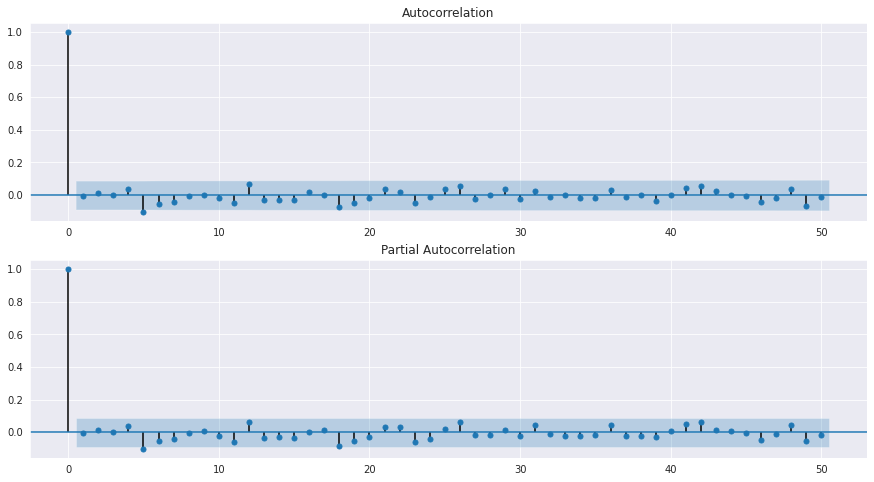

In [36]:
res = best_model.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

# SARIMA Test Results 

## BoxCox

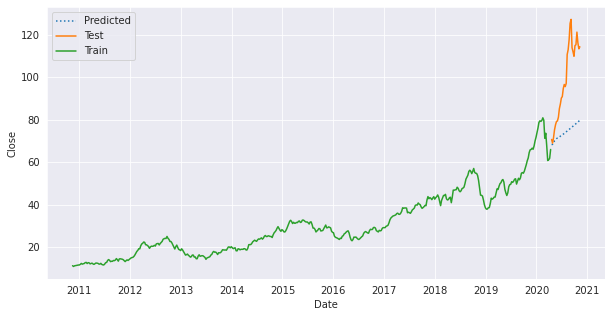

In [33]:
# Get predictions
start_idx = len(train_data)
end_idx = len(train_data) + len(test_data) - 1
predictions = sarima_model.predict(start_idx, end_idx, typ = 'levels')

# Apply an inverse Box-Cox transform to get back original scale
predictions_inv = inv_boxcox(predictions, boxcox_lambda)

# Plot training, testing, and predictions
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = predictions.index, y = predictions_inv, ax = ax, linestyle = ':');
sns.lineplot(x = test_data.index, y = test_data['Close'], ax = ax);
sns.lineplot(x = train_data.index, y = train_data['Close'], ax = ax);
ax.legend(['Predicted', 'Test', 'Train']);

In [37]:
rmse = mean_squared_error(test_data['Close'], predictions_inv, squared = False)
print('SARIMA model With Box-Cox Transformation')
print(f'RMSE: {rmse}')

SARIMA model With Box-Cox Transformation
RMSE: 28.852805966435913


## Non-BoxCox

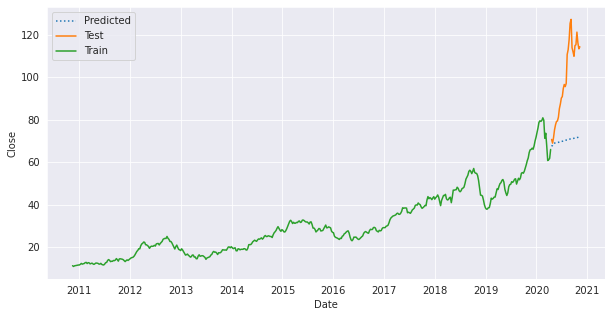

In [38]:
# Get predictions
start_idx = len(train_data)
end_idx = len(train_data) + len(test_data) - 1
predictions = best_model.predict(start_idx, end_idx, typ = 'levels')

# Plot training, testing, and predictions
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = predictions.index, y = predictions, ax = ax, linestyle = ':');
sns.lineplot(x = test_data.index, y = test_data['Close'], ax = ax);
sns.lineplot(x = train_data.index, y = train_data['Close'], ax = ax);
ax.legend(['Predicted', 'Test', 'Train']);


In [39]:
rmse = mean_squared_error(test_data['Close'], predictions, squared = False)
print('SARIMA model Without Box-Cox Transformation')
print(f'RMSE: {rmse}')

SARIMA model Without Box-Cox Transformation
RMSE: 33.21819200426276
